In [ ]:
import cupy as np
import sys
import pdb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import statistics

def get_data(x_path, y_path):
    '''
    Args:
        x_path: path to x file
        y_path: path to y file
    Returns:
        x: np array of [NUM_OF_SAMPLES x n]
        y: np array of [NUM_OF_SAMPLES]
    '''
    x = np.load(x_path)
    y = np.load(y_path)

    x = x.astype('float')

    #normalize each example in x to have 0 mean and 1 std

    # Calculate the mean and standard deviation for each feature
    feature_means = np.mean(x, axis=0)
    feature_stds = np.std(x, axis=0)
    feature_stds = feature_stds + (feature_stds == 0)

    # Normalize each feature to have 0 mean and 1 std
    x = (x - feature_means) / (feature_stds)

    # Adjust labels to start from 0 if they start from 1
    y = y - 1

    return x, y

def get_metric(y_true, y_pred):
    '''
    Args:
        y_true: np array of [NUM_SAMPLES x r] (one hot)
                or np array of [NUM_SAMPLES]
        y_pred: np array of [NUM_SAMPLES x r] (one hot)
                or np array of [NUM_SAMPLES]

    '''
    results = classification_report(y_pred, y_true)
    print(results)

In [ ]:
x_test, y_test = get_data('x_test.npy', 'y_test.npy')
x_train, y_train = get_data('x_train.npy', 'y_train.npy')

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10000, 1024), (10000,), (1000, 1024), (1000,))

In [ ]:
x_train[0]

array([-0.39813868,  0.1879447 ,  0.91463024, ..., -0.15117837,
        0.26519742,  0.        ])

In [ ]:
label_encoder = OneHotEncoder(sparse_output = False)
label_encoder.fit(np.expand_dims(y_train, axis = -1).get())

y_train_onehot = np.asarray(label_encoder.transform(np.expand_dims(y_train, axis = -1).get()))
y_test_onehot = np.asarray(label_encoder.transform(np.expand_dims(y_test, axis = -1).get()))

In [ ]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        """
        Initializes the neural network with the given layer sizes.
        layer_sizes is a list of integers, where the i-th integer represents
        the number of neurons in the i-th layer.
        """
        self.layer_sizes = layer_sizes
        self.weights = []
        self.biases = []
        self.activations = []

        # Initialize weights and biases for each layer
        for i in range(len(layer_sizes) - 1):
            # Weights are initialized with small random values
            self.weights.append(np.random.randn(layer_sizes[i+1], layer_sizes[i]) * 0.01)
            self.biases.append(np.zeros((layer_sizes[i+1], 1)))

    def sigmoid(self, z):
        """
        The sigmoid activation function.
        """
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        """
        The softmax function.
        """
        e_z = np.exp(z)  # Subtracting np.max(z) for numerical stability
        return e_z / e_z.sum(axis=0, keepdims=True)

    def feedforward(self, x):
        """
        Performs a feedforward computation.
        """
        activation = x
        self.activations = [x]  # List to store all the activations, layer by layer

        # Compute activations for each layer
        for w, b in zip(self.weights, self.biases):
            z = np.dot(w, activation) + b
            activation = self.sigmoid(z) if w is not self.weights[-1] else self.softmax(z)
            self.activations.append(activation)

        return self.activations[-1]  # The final activation is the output of the network

# Let's test the initialization and feedforward computation with a small network
nn = NeuralNetwork([1024, 100, 5])  # A network with 1024 input features, one hidden layer with 100 neurons, and 5 output classes
sample_input = np.random.randn(1024, 1)  # A random sample input
output = nn.feedforward(sample_input)  # Perform a feedforward computation

output  # Display the output probabilities

array([[0.20967439],
       [0.19061293],
       [0.18527092],
       [0.20562508],
       [0.20881668]])

In [ ]:
class NeuralNetwork(NeuralNetwork):  # Extending the previously defined NeuralNetwork class
    def cross_entropy_loss(self, y_pred, y_true):
        """
        Computes the cross-entropy loss.
        """
        m = y_true.shape[1]  # Number of examples
        # To avoid division by zero, we clip the predictions to a minimum value
        # y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        # Compute the cross-entropy loss
        loss = -np.sum(y_true * np.log(y_pred)) / m
        return loss

    def backpropagation(self, y_true):
        """
        Performs backpropagation to compute the gradients of the loss function
        with respect to the weights and biases.
        """
        m = y_true.shape[1]  # Number of examples
        y_pred = self.activations[-1]  # The output of the last layer
        y_true = y_true.reshape(y_pred.shape)  # Ensure same shape

        # Initialize gradients for each layer
        d_weights = [np.zeros(w.shape) for w in self.weights]
        d_biases = [np.zeros(b.shape) for b in self.biases]

        # Calculate derivative of loss w.r.t. the last layer output
        d_loss = y_pred - y_true

        for i in reversed(range(len(d_weights))):
            d_activations = d_loss * self.sigmoid_derivative(self.activations[i+1]) if i != len(d_weights) - 1 else d_loss
            d_weights[i] = np.dot(d_activations, self.activations[i].T) / m
            d_biases[i] = np.sum(d_activations, axis=1, keepdims=True) / m
            if i != 0:
                d_loss = np.dot(self.weights[i].T, d_activations)

        return d_weights, d_biases

    def sigmoid_derivative(self, s):
        """
        Derivative of the sigmoid function.
        """
        return s * (1 - s)

    def update_parameters(self, d_weights, d_biases, learning_rate):
        """
        Updates the parameters using the computed gradients.
        """
        # Update each parameter with a simple gradient descent step
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * d_weights[i]
            self.biases[i] -= learning_rate * d_biases[i]

    def train(self, x_train, y_train, epochs, mini_batch_size, learning_rate, conv_threshold = 0.001, conv_epochs = 5):
        n = x_train.shape[1]  # Total number of training examples

        # Training loop
        loss_history = []
        permutation = np.random.permutation(n)
        for epoch in range(epochs):
            # Shuffle the training data for each epoch
            x_train_shuffled = x_train[:, permutation]
            y_train_shuffled = y_train[:, permutation]

            # Mini-batch loop
            for k in range(0, n, mini_batch_size):
                mini_batch_x = x_train_shuffled[:, k:k + mini_batch_size]
                mini_batch_y = y_train_shuffled[:, k:k + mini_batch_size]
                # Forward pass
                self.feedforward(mini_batch_x)
                # Backward pass
                d_weights, d_biases = self.backpropagation(mini_batch_y)
                # Update parameters
                self.update_parameters(d_weights, d_biases, learning_rate)

            loss = self.cross_entropy_loss(self.feedforward(x_train), y_train)
            # Optional: Print the loss after each epoch (can be commented out for speed)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

            loss_history.append(float(loss))

            if len(loss_history) > conv_epochs:
                temp = loss_history[-conv_epochs:]
                if statistics.stdev(temp) < conv_threshold:
                    print('Converged')
                    break

In [ ]:
# Create a fresh instance of the neural network with the corrected train method
nn = NeuralNetwork([1024, 100, 5])
# Convert labels to one-hot encoding again
y_train_one_hot = np.eye(5)[y_train].T

# Train the neural network again with the corrected training method
nn.train(x_train.T, y_train_one_hot, epochs=1000, mini_batch_size=32, learning_rate=0.01)

Epoch 1/1000, Loss: 1.3209
Epoch 2/1000, Loss: 0.9888
Epoch 3/1000, Loss: 0.8633
Epoch 4/1000, Loss: 0.7913
Epoch 5/1000, Loss: 0.7416
Epoch 6/1000, Loss: 0.7035
Epoch 7/1000, Loss: 0.6723
Epoch 8/1000, Loss: 0.6458
Epoch 9/1000, Loss: 0.6226
Epoch 10/1000, Loss: 0.6021
Epoch 11/1000, Loss: 0.5837
Epoch 12/1000, Loss: 0.5670
Epoch 13/1000, Loss: 0.5519
Epoch 14/1000, Loss: 0.5381
Epoch 15/1000, Loss: 0.5255
Epoch 16/1000, Loss: 0.5138
Epoch 17/1000, Loss: 0.5030
Epoch 18/1000, Loss: 0.4930
Epoch 19/1000, Loss: 0.4837
Epoch 20/1000, Loss: 0.4749
Epoch 21/1000, Loss: 0.4667
Epoch 22/1000, Loss: 0.4590
Epoch 23/1000, Loss: 0.4517
Epoch 24/1000, Loss: 0.4448
Epoch 25/1000, Loss: 0.4383
Epoch 26/1000, Loss: 0.4321
Epoch 27/1000, Loss: 0.4262
Epoch 28/1000, Loss: 0.4205
Epoch 29/1000, Loss: 0.4151
Epoch 30/1000, Loss: 0.4100
Epoch 31/1000, Loss: 0.4050
Epoch 32/1000, Loss: 0.4003
Epoch 33/1000, Loss: 0.3957
Epoch 34/1000, Loss: 0.3913
Epoch 35/1000, Loss: 0.3871
Epoch 36/1000, Loss: 0.3830
E

In [ ]:
# Compute the accuracy on the training and test sets
y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
print(f"Training accuracy: {np.mean(y_train_pred == y_train) * 100}%")
print(f"Test accuracy: {np.mean(y_test_pred == y_test) * 100}%")

Training accuracy: 100.0%
Test accuracy: 86.2%


# part b

In [ ]:
y_train_one_hot = np.eye(5)[y_train].T

In [ ]:
hidden_layer_sizes = [1, 5, 10, 50, 100]
model_with_hidden_layer_size = {}

for hidden_layer_size in hidden_layer_sizes:

    print(f'hidden_layer_size: {hidden_layer_size}')
    nn = NeuralNetwork([1024, hidden_layer_size, 5])
    nn.train(x_train.T, y_train_one_hot, epochs=200, mini_batch_size=32, learning_rate=0.01)
    model_with_hidden_layer_size[hidden_layer_size] = nn

hidden_layer_size: 1
Epoch 1/200, Loss: 1.6091
Epoch 2/200, Loss: 1.6033
Epoch 3/200, Loss: 1.5492
Epoch 4/200, Loss: 1.4840
Epoch 5/200, Loss: 1.4272
Epoch 6/200, Loss: 1.3788
Epoch 7/200, Loss: 1.3379
Epoch 8/200, Loss: 1.3030
Epoch 9/200, Loss: 1.2731
Epoch 10/200, Loss: 1.2472
Epoch 11/200, Loss: 1.2247
Epoch 12/200, Loss: 1.2048
Epoch 13/200, Loss: 1.1872
Epoch 14/200, Loss: 1.1715
Epoch 15/200, Loss: 1.1573
Epoch 16/200, Loss: 1.1444
Epoch 17/200, Loss: 1.1326
Epoch 18/200, Loss: 1.1219
Epoch 19/200, Loss: 1.1120
Epoch 20/200, Loss: 1.1028
Epoch 21/200, Loss: 1.0944
Epoch 22/200, Loss: 1.0864
Epoch 23/200, Loss: 1.0790
Epoch 24/200, Loss: 1.0720
Epoch 25/200, Loss: 1.0655
Epoch 26/200, Loss: 1.0593
Epoch 27/200, Loss: 1.0534
Epoch 28/200, Loss: 1.0478
Epoch 29/200, Loss: 1.0424
Epoch 30/200, Loss: 1.0373
Epoch 31/200, Loss: 1.0325
Epoch 32/200, Loss: 1.0278
Epoch 33/200, Loss: 1.0233
Epoch 34/200, Loss: 1.0189
Epoch 35/200, Loss: 1.0148
Epoch 36/200, Loss: 1.0107
Epoch 37/200, Lo

KeyboardInterrupt: ignored

In [ ]:
for hidden_layer_size in hidden_layer_sizes:
    nn = model_with_hidden_layer_size[hidden_layer_size]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred, y_train)
    print(f"{hidden_layer_size} hidden layer size")
    print('Training')
    print(results)

    results = classification_report(y_test_pred, y_test)
    print('Test')
    print(results)

1 hidden layer size
Training
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      2589
           1       0.63      0.89      0.74      1410
           2       0.78      0.85      0.81      1782
           3       0.40      0.73      0.52      1114
           4       0.98      0.66      0.79      3105

    accuracy                           0.76     10000
   macro avg       0.76      0.78      0.74     10000
weighted avg       0.84      0.76      0.78     10000

Test
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       258
           1       0.73      0.91      0.81       158
           2       0.67      0.78      0.72       170
           3       0.32      0.55      0.40       107
           4       0.98      0.60      0.74       307

    accuracy                           0.75      1000
   macro avg       0.74      0.75      0.72      1000
weighted avg       0.82      0.75      0.76

In [ ]:
avg_f1_scores_training = []
avg_f1_scores_test = []
for hidden_layer_size in hidden_layer_sizes:
    nn = model_with_hidden_layer_size[hidden_layer_size]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred, y_train, output_dict=True)
    avg_f1_scores_training.append(results['weighted avg']['f1-score'])

    results = classification_report(y_test_pred, y_test, output_dict=True)
    avg_f1_scores_test.append(results['weighted avg']['f1-score'])

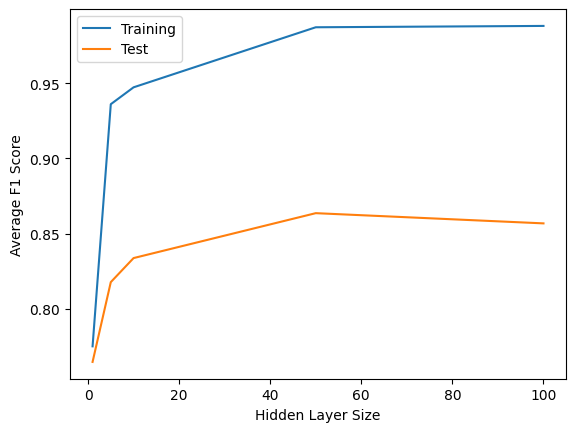

In [ ]:
plt.plot(hidden_layer_sizes, avg_f1_scores_training, label = 'Training')
plt.plot(hidden_layer_sizes, avg_f1_scores_test, label = 'Test')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Average F1 Score')
plt.legend()
plt.savefig('(b) f1 vs hidden_size.png')

# part c

In [ ]:
hidden_layers = [[512], [512, 256], [512, 256, 128], [512, 256, 128, 64]]
layers = [[1024] + hidden_layer + [5] for hidden_layer in hidden_layers]
model_with_hidden_layers = {}
y_train_one_hot = np.eye(5)[y_train].T

for layer in layers:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train(x_train.T, y_train_one_hot, epochs=200, mini_batch_size=32, learning_rate=0.01)
    model_with_hidden_layers[str(layer)] = nn

hidden_layer_size: [1024, 512, 5]
Epoch 1/200, Loss: 1.1080
Epoch 2/200, Loss: 0.8624
Epoch 3/200, Loss: 0.7557
Epoch 4/200, Loss: 0.6931
Epoch 5/200, Loss: 0.6500
Epoch 6/200, Loss: 0.6173
Epoch 7/200, Loss: 0.5908
Epoch 8/200, Loss: 0.5685
Epoch 9/200, Loss: 0.5493
Epoch 10/200, Loss: 0.5323
Epoch 11/200, Loss: 0.5173
Epoch 12/200, Loss: 0.5037
Epoch 13/200, Loss: 0.4915
Epoch 14/200, Loss: 0.4804
Epoch 15/200, Loss: 0.4703
Epoch 16/200, Loss: 0.4611
Epoch 17/200, Loss: 0.4526
Epoch 18/200, Loss: 0.4448
Epoch 19/200, Loss: 0.4377
Epoch 20/200, Loss: 0.4310
Epoch 21/200, Loss: 0.4248
Epoch 22/200, Loss: 0.4190
Epoch 23/200, Loss: 0.4136
Epoch 24/200, Loss: 0.4085
Epoch 25/200, Loss: 0.4037
Epoch 26/200, Loss: 0.3992
Epoch 27/200, Loss: 0.3949
Epoch 28/200, Loss: 0.3908
Epoch 29/200, Loss: 0.3869
Epoch 30/200, Loss: 0.3832
Epoch 31/200, Loss: 0.3796
Epoch 32/200, Loss: 0.3762
Epoch 33/200, Loss: 0.3728
Epoch 34/200, Loss: 0.3697
Epoch 35/200, Loss: 0.3666
Epoch 36/200, Loss: 0.3636
Epo

In [ ]:
for layer in layers[-2:]:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train(x_train.T, y_train_one_hot, epochs=200, mini_batch_size=32, learning_rate=0.01, conv_threshold=1e-5)
    model_with_hidden_layers[str(layer)] = nn

hidden_layer_size: [1024, 512, 256, 128, 5]
Epoch 1/200, Loss: 1.6102
Epoch 2/200, Loss: 1.6101
Epoch 3/200, Loss: 1.6101
Epoch 4/200, Loss: 1.6101
Epoch 5/200, Loss: 1.6101
Epoch 6/200, Loss: 1.6101
Converged
hidden_layer_size: [1024, 512, 256, 128, 64, 5]
Epoch 1/200, Loss: 1.6098
Epoch 2/200, Loss: 1.6098
Epoch 3/200, Loss: 1.6098
Epoch 4/200, Loss: 1.6098
Epoch 5/200, Loss: 1.6097
Epoch 6/200, Loss: 1.6097
Converged


In [ ]:
for layer in layers[-1:]:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train(x_train.T, y_train_one_hot, epochs=100, mini_batch_size=32, learning_rate=0.1, conv_threshold=1e-5)
    model_with_hidden_layers[str(layer)] = nn

hidden_layer_size: [1024, 512, 256, 128, 64, 5]
Epoch 1/100, Loss: 1.6194
Epoch 2/100, Loss: 1.6181
Epoch 3/100, Loss: 1.6170
Epoch 4/100, Loss: 1.6160
Epoch 5/100, Loss: 1.6152
Epoch 6/100, Loss: 1.6144
Epoch 7/100, Loss: 1.6137
Epoch 8/100, Loss: 1.6131
Epoch 9/100, Loss: 1.6127
Epoch 10/100, Loss: 1.6122
Epoch 11/100, Loss: 1.6119
Epoch 12/100, Loss: 1.6116
Epoch 13/100, Loss: 1.6113
Epoch 14/100, Loss: 1.6111
Epoch 15/100, Loss: 1.6109
Epoch 16/100, Loss: 1.6108
Epoch 17/100, Loss: 1.6106
Epoch 18/100, Loss: 1.6105
Epoch 19/100, Loss: 1.6104
Epoch 20/100, Loss: 1.6103
Epoch 21/100, Loss: 1.6102
Epoch 22/100, Loss: 1.6102
Epoch 23/100, Loss: 1.6101
Epoch 24/100, Loss: 1.6101
Epoch 25/100, Loss: 1.6100
Epoch 26/100, Loss: 1.6100
Epoch 27/100, Loss: 1.6099
Epoch 28/100, Loss: 1.6099
Epoch 29/100, Loss: 1.6099
Epoch 30/100, Loss: 1.6098
Epoch 31/100, Loss: 1.6098
Epoch 32/100, Loss: 1.6098
Epoch 33/100, Loss: 1.6097
Epoch 34/100, Loss: 1.6097
Epoch 35/100, Loss: 1.6097
Epoch 36/100, Lo

In [ ]:
for layer in layers[-2:-1]:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train(x_train.T, y_train_one_hot, epochs=50, mini_batch_size=32, learning_rate=0.1, conv_threshold=1e-5)
    model_with_hidden_layers[str(layer)] = nn

hidden_layer_size: [1024, 512, 256, 128, 5]
Epoch 1/50, Loss: 1.6404
Epoch 2/50, Loss: 1.6236
Epoch 3/50, Loss: 1.6158
Epoch 4/50, Loss: 1.6126
Epoch 5/50, Loss: 1.6112
Epoch 6/50, Loss: 1.6106
Epoch 7/50, Loss: 1.6099
Epoch 8/50, Loss: 1.6082
Epoch 9/50, Loss: 1.6002
Epoch 10/50, Loss: 1.5423
Epoch 11/50, Loss: 1.2800
Epoch 12/50, Loss: 0.9937
Epoch 13/50, Loss: 0.8773
Epoch 14/50, Loss: 0.8036
Epoch 15/50, Loss: 0.7420
Epoch 16/50, Loss: 0.6827
Epoch 17/50, Loss: 0.6149
Epoch 18/50, Loss: 0.5357
Epoch 19/50, Loss: 0.4717
Epoch 20/50, Loss: 0.4276
Epoch 21/50, Loss: 0.3970
Epoch 22/50, Loss: 0.3752
Epoch 23/50, Loss: 0.3587
Epoch 24/50, Loss: 0.3452
Epoch 25/50, Loss: 0.3333
Epoch 26/50, Loss: 0.3222
Epoch 27/50, Loss: 0.3114
Epoch 28/50, Loss: 0.3009
Epoch 29/50, Loss: 0.2904
Epoch 30/50, Loss: 0.2800
Epoch 31/50, Loss: 0.2698
Epoch 32/50, Loss: 0.2596
Epoch 33/50, Loss: 0.2494
Epoch 34/50, Loss: 0.2392
Epoch 35/50, Loss: 0.2291
Epoch 36/50, Loss: 0.2188
Epoch 37/50, Loss: 0.2085
Epo

In [ ]:
# save models
import pickle

with open('models_c.pickle', 'wb') as handle:
    pickle.dump(model_with_hidden_layers, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import shutil



In [ ]:
shutil.copy("models_c.pickle","/content/drive/MyDrive/models_c.pickle")

'/content/drive/MyDrive/models_c.pickle'

In [ ]:
for layer in layers:
    nn = model_with_hidden_layers[str(layer)]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred.get(), y_train.get())
    print(f"{layer} hidden layer size")
    print('Training')
    print(results)

    results = classification_report(y_test_pred.get(), y_test.get())
    print('Test')
    print(results)

[1024, 512, 5] hidden layer size
Training
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1978
           1       0.97      0.96      0.97      1989
           2       0.93      0.94      0.94      1941
           3       0.94      0.94      0.94      2013
           4       0.97      0.98      0.97      2079

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       224
           1       0.89      0.92      0.90       191
           2       0.78      0.80      0.79       194
           3       0.70      0.72      0.71       181
           4       0.91      0.81      0.86       210

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.86      0

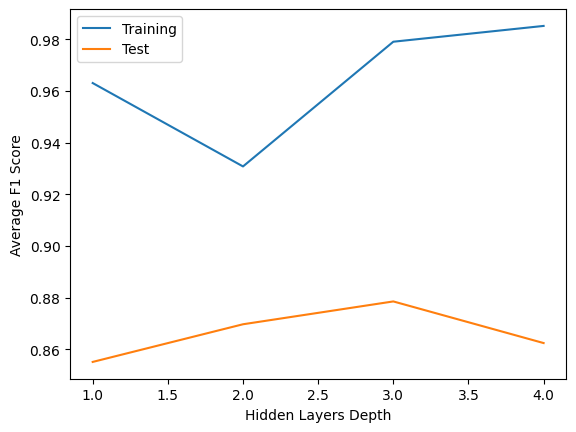

In [ ]:
avg_f1_scores_training = []
avg_f1_scores_test = []
for layer in layers:
    nn = model_with_hidden_layers[str(layer)]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred.get(), y_train.get(), output_dict=True)
    avg_f1_scores_training.append(results['weighted avg']['f1-score'])

    results = classification_report(y_test_pred.get(), y_test.get(), output_dict=True)
    avg_f1_scores_test.append(results['weighted avg']['f1-score'])

plt.plot([len(layer)-2 for layer in layers], avg_f1_scores_training, label = 'Training')
plt.plot([len(layer)-2 for layer in layers], avg_f1_scores_test, label = 'Test')
plt.xlabel('Hidden Layers Depth')
plt.ylabel('Average F1 Score')
plt.legend()
plt.savefig('(c) f1 vs hidden_depth.png')
plt.show()

# part d


In [ ]:
class NeuralNetwork(NeuralNetwork):  # Extending the previously defined NeuralNetwork class
    def train_c(self, x_train, y_train, epochs, mini_batch_size, learning_rate, conv_threshold = 0.001, conv_epochs = 5):
        n = x_train.shape[1]  # Total number of training examples

        # Training loop
        loss_history = []
        permutation = np.random.permutation(n)
        learning_rate_c = learning_rate
        for epoch in range(epochs):
            learning_rate = learning_rate_c / pow(epoch+1, 0.5)
            # Shuffle the training data for each epoch
            x_train_shuffled = x_train[:, permutation]
            y_train_shuffled = y_train[:, permutation]

            # Mini-batch loop
            for k in range(0, n, mini_batch_size):
                mini_batch_x = x_train_shuffled[:, k:k + mini_batch_size]
                mini_batch_y = y_train_shuffled[:, k:k + mini_batch_size]
                # Forward pass
                self.feedforward(mini_batch_x)
                # Backward pass
                d_weights, d_biases = self.backpropagation(mini_batch_y)
                # Update parameters
                self.update_parameters(d_weights, d_biases, learning_rate)

            loss = self.cross_entropy_loss(self.feedforward(x_train), y_train)
            # Optional: Print the loss after each epoch (can be commented out for speed)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

            loss_history.append(float(loss))

            if len(loss_history) > conv_epochs:
                temp = loss_history[-conv_epochs:]
                if statistics.stdev(temp) < conv_threshold:
                    print('Converged')
                    break

In [ ]:
models_d = {}
for layer in layers:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train_c(x_train.T, y_train_one_hot, epochs=200, mini_batch_size=32, learning_rate=0.01)
    models_d[str(layer)] = nn

hidden_layer_size: [1024, 512, 5]
Epoch 1/200, Loss: 1.0932
Epoch 2/200, Loss: 0.8931
Epoch 3/200, Loss: 0.8071
Epoch 4/200, Loss: 0.7566
Epoch 5/200, Loss: 0.7224
Epoch 6/200, Loss: 0.6971
Epoch 7/200, Loss: 0.6773
Epoch 8/200, Loss: 0.6611
Epoch 9/200, Loss: 0.6475
Epoch 10/200, Loss: 0.6359
Epoch 11/200, Loss: 0.6256
Epoch 12/200, Loss: 0.6166
Epoch 13/200, Loss: 0.6084
Epoch 14/200, Loss: 0.6010
Epoch 15/200, Loss: 0.5942
Epoch 16/200, Loss: 0.5879
Epoch 17/200, Loss: 0.5821
Epoch 18/200, Loss: 0.5767
Epoch 19/200, Loss: 0.5717
Epoch 20/200, Loss: 0.5669
Epoch 21/200, Loss: 0.5624
Epoch 22/200, Loss: 0.5582
Epoch 23/200, Loss: 0.5541
Epoch 24/200, Loss: 0.5503
Epoch 25/200, Loss: 0.5466
Epoch 26/200, Loss: 0.5432
Epoch 27/200, Loss: 0.5398
Epoch 28/200, Loss: 0.5366
Epoch 29/200, Loss: 0.5335
Epoch 30/200, Loss: 0.5306
Epoch 31/200, Loss: 0.5277
Epoch 32/200, Loss: 0.5250
Epoch 33/200, Loss: 0.5223
Epoch 34/200, Loss: 0.5197
Epoch 35/200, Loss: 0.5173
Epoch 36/200, Loss: 0.5149
Epo

In [ ]:
# save models
import pickle

with open('models_d.pickle', 'wb') as handle:
    pickle.dump(models_d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
shutil.copy("models_d.pickle","/content/drive/MyDrive/models_d.pickle")

'/content/drive/MyDrive/models_d.pickle'

In [ ]:
for layer in layers[-2:]:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train(x_train.T, y_train_one_hot, epochs=100, mini_batch_size=32, learning_rate=0.1, conv_threshold=1e-5)
    models_d[str(layer)] = nn

hidden_layer_size: [1024, 512, 256, 128, 5]
Epoch 1/100, Loss: 1.6756
Epoch 2/100, Loss: 1.6535
Epoch 3/100, Loss: 1.6387
Epoch 4/100, Loss: 1.6292
Epoch 5/100, Loss: 1.6232
Epoch 6/100, Loss: 1.6194
Epoch 7/100, Loss: 1.6166
Epoch 8/100, Loss: 1.6136
Epoch 9/100, Loss: 1.6057
Epoch 10/100, Loss: 1.5582
Epoch 11/100, Loss: 1.3181
Epoch 12/100, Loss: 1.0186
Epoch 13/100, Loss: 0.9033
Epoch 14/100, Loss: 0.8318
Epoch 15/100, Loss: 0.7712
Epoch 16/100, Loss: 0.7157
Epoch 17/100, Loss: 0.6568
Epoch 18/100, Loss: 0.5859
Epoch 19/100, Loss: 0.5128
Epoch 20/100, Loss: 0.4561
Epoch 21/100, Loss: 0.4156
Epoch 22/100, Loss: 0.3876
Epoch 23/100, Loss: 0.3672
Epoch 24/100, Loss: 0.3511
Epoch 25/100, Loss: 0.3372
Epoch 26/100, Loss: 0.3247
Epoch 27/100, Loss: 0.3129
Epoch 28/100, Loss: 0.3016
Epoch 29/100, Loss: 0.2906
Epoch 30/100, Loss: 0.2797
Epoch 31/100, Loss: 0.2688
Epoch 32/100, Loss: 0.2579
Epoch 33/100, Loss: 0.2469
Epoch 34/100, Loss: 0.2357
Epoch 35/100, Loss: 0.2246
Epoch 36/100, Loss: 

[1024, 512, 5] hidden layer size
Training
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2006
           1       0.88      0.88      0.88      1976
           2       0.74      0.77      0.76      1887
           3       0.67      0.71      0.69      1891
           4       0.88      0.82      0.85      2240

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Test
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       226
           1       0.84      0.90      0.87       184
           2       0.69      0.76      0.73       181
           3       0.64      0.66      0.65       181
           4       0.91      0.75      0.82       228

    accuracy                           0.82      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.82      0

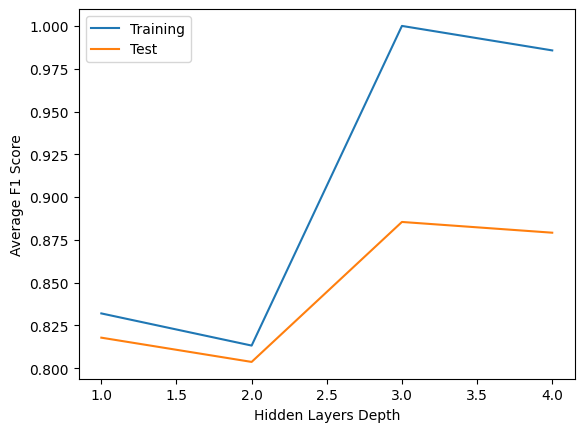

In [ ]:
for layer in layers:
    nn = models_d[str(layer)]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred.get(), y_train.get())
    print(f"{layer} hidden layer size")
    print('Training')
    print(results)

    results = classification_report(y_test_pred.get(), y_test.get())
    print('Test')
    print(results)
avg_f1_scores_training = []
avg_f1_scores_test = []
for layer in layers:
    nn = models_d[str(layer)]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred.get(), y_train.get(), output_dict=True)
    avg_f1_scores_training.append(results['weighted avg']['f1-score'])

    results = classification_report(y_test_pred.get(), y_test.get(), output_dict=True)
    avg_f1_scores_test.append(results['weighted avg']['f1-score'])

plt.plot([len(layer)-2 for layer in layers], avg_f1_scores_training, label = 'Training')
plt.plot([len(layer)-2 for layer in layers], avg_f1_scores_test, label = 'Test')
plt.xlabel('Hidden Layers Depth')
plt.ylabel('Average F1 Score')
plt.legend()
plt.savefig('(d) f1 vs hidden_depth.png')
plt.show()

# part f

In [ ]:
from sklearn.metrics import f1_score

models_f = {}
for hidden_layer in hidden_layers:
    print(f'hidden_layer_size: {hidden_layer}')
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer,
                        activation='relu',
                        solver='sgd',
                        alpha=0,
                        batch_size=32,
                        learning_rate='invscaling',
                        max_iter=200,
                        n_iter_no_change=5,
                        verbose=True)
    mlp.fit(x_train, y_train)

    models_f[str(hidden_layer_size)] = mlp

hidden_layer_size: [512]
Iteration 1, loss = 0.85098997
Iteration 2, loss = 0.59706419
Iteration 3, loss = 0.59042063
Iteration 4, loss = 0.58687388
Iteration 5, loss = 0.58450515
Iteration 6, loss = 0.58268417
Iteration 7, loss = 0.58117875
Iteration 8, loss = 0.57990014
Iteration 9, loss = 0.57877349
Iteration 10, loss = 0.57777492
Iteration 11, loss = 0.57685872
Iteration 12, loss = 0.57602095
Iteration 13, loss = 0.57523868
Iteration 14, loss = 0.57451889
Iteration 15, loss = 0.57384004
Iteration 16, loss = 0.57319678
Iteration 17, loss = 0.57259446
Iteration 18, loss = 0.57201568
Iteration 19, loss = 0.57147014
Iteration 20, loss = 0.57094349
Iteration 21, loss = 0.57044027
Iteration 22, loss = 0.56995713
Iteration 23, loss = 0.56948431
Iteration 24, loss = 0.56903466
Iteration 25, loss = 0.56860076
Iteration 26, loss = 0.56817817
Iteration 27, loss = 0.56777220
Iteration 28, loss = 0.56736976
Iteration 29, loss = 0.56698630
Iteration 30, loss = 0.56660851
Iteration 31, loss = 0.5

In [ ]:
# save models
import pickle

with open('pickles/models_f.pickle', 'wb') as handle:
    pickle.dump(models_f, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
# load models
with open('pickles/models_f.pickle', 'rb') as handle:
    models_f = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: 'pickles/models_f.pickle'